In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os
import keras
from keras import regularizers
from keras import layers
from keras.models import Sequential
from keras import optimizers

print(tf.__version__)

2.2.0


Using TensorFlow backend.


In [0]:
# Useful Constants

augmentation_amount = 20

normalization_method = "wh"

# Output classes to learn how to classify
LABELS = [    
  "friend",
  "toy",
  "stabbed",
  "glass",
  "baby",
  "can't breath",
  "swallow",
  "break",
  "foot",
  "hornet",
  "poison",
  "faint",
  "burned",
  "dyspnoea",
  "sinked",
  "bleed",
  "vomit",
  "dislocation",
  "childbirth",
  "fall",
  "pale",
  "choke",
  "cut",
  "run a temperature",
  "dizzy",
  "fall down",
  "heart attack",
  "colic",
  "seizure",
  "spotty",
  "hives",
  "fracture",
  "high fever",
  "itchy"
]
DATASET_PATH = "/content/drive/My Drive/Capstone/csv3/augmentation x "+str(augmentation_amount)+"/"

X_train_path = DATASET_PATH + "X_train_"+normalization_method+".csv"
X_test_path = DATASET_PATH + "X_test_"+normalization_method+".csv"

n_steps = 50 # 50 timesteps per series

In [0]:
# Load the networks inputs

X_df_train = pd.read_csv(X_train_path, header=None).to_numpy()
blocks = int(len(X_df_train) / n_steps)
X_pre_train = np.array(np.split(X_df_train,blocks))

In [0]:
X_df_test = pd.read_csv(X_test_path, header=None).to_numpy()
blocks = int(len(X_df_test) / n_steps)
X_test = np.array(np.split(X_df_test,blocks))

#X_test = load_X(X_test_path)
print(X_pre_train.shape)
print(X_test.shape)

(25200, 50, 108)
(2800, 50, 108)


##y_train, y_val, y_test

In [0]:
y_test = []
y_pre_train = []

##y_test
for i in range(35):
  for j in range(4*augmentation_amount):
    y_test.append(i)

y_test = np.asarray(y_test)

##y_pre_train ##if necessary
for i in range(35):
  for j in range(16*augmentation_amount):
    y_pre_train.append(i)

for i in range(4):
  for j in range(35):
    for k in range(5*augmentation_amount):
      y_pre_train.append(j)

y_pre_train = np.asarray(y_pre_train)

print(y_pre_train.shape)

(25200,)


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_pre_train, y_pre_train, test_size = 0.3, random_state=64)

In [0]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(17640, 50, 108) (7560, 50, 108) (17640,) (7560,)


In [0]:
def GRU_RNN(n_input_, n_hidden_, n_classes_, lambda_loss_amount_, batch_size_):
  return Sequential([
   # relu activation
   layers.Dense(n_hidden_, activation='relu', 
       kernel_initializer='random_normal', 
       bias_initializer='random_normal',
       batch_input_shape=(batch_size_, n_steps, n_input_)
   ),
   layers.GRU(n_hidden_, return_sequences=True),
   layers.Dropout(0.2),
   layers.GRU(n_hidden_, return_sequences=True),
   layers.GRU(n_hidden_, return_sequences=True),
   layers.GRU(n_hidden_, return_sequences=True),
   layers.GRU(n_hidden_),

   layers.Dense(n_classes_, kernel_initializer='random_normal', 
       bias_initializer='random_normal',
       kernel_regularizer=regularizers.l2(lambda_loss_amount_),
       bias_regularizer=regularizers.l2(lambda_loss_amount_),
       activation='softmax'
   )
  ])

##Train it!

In [0]:
from keras.callbacks import EarlyStopping

# Input Data 
n_input = len(X_train[0][0])
n_hidden = 256 # Hidden layer num of features
n_classes = 35
learning_rate = 0.0007 #used if decaying_learning_rate set to False
decay_rate = 0.02 #the base of the exponential in the decay
lambda_loss_amount = 0.0015

training_epochs = 100
batch_size = 64

model = GRU_RNN(n_input, n_hidden, n_classes, lambda_loss_amount, batch_size)

model.compile(
   optimizer=optimizers.Adam(lr=learning_rate, decay=decay_rate),
   metrics=['accuracy'],
   loss='categorical_crossentropy'
)

y_train_one_hot = keras.utils.to_categorical(y_train, 35)
y_val_one_hot = keras.utils.to_categorical(y_val, 35)
y_test_one_hot = keras.utils.to_categorical(y_test, 35)

train_size = X_train.shape[0] - X_train.shape[0] % batch_size
val_size = X_val.shape[0] - X_val.shape[0] % batch_size
test_size = X_test.shape[0] - X_test.shape[0] % batch_size

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, min_delta=0.005)

history = model.fit(
   X_train[:train_size,:,:], 
   y_train_one_hot[:train_size,:],
   epochs=training_epochs,
   batch_size=batch_size,
   validation_data=(X_val[:val_size,:,:], y_val_one_hot[:val_size,:]),
   callbacks=[es]
)

Train on 17600 samples, validate on 7552 samples
Epoch 1/100
17600/17600 [==============================] - 53s 3ms/step - loss: 2.8428 - accuracy: 0.2032 - val_loss: 2.1797 - val_accuracy: 0.3701
Epoch 2/100
17600/17600 [==============================] - 51s 3ms/step - loss: 1.8949 - accuracy: 0.4733 - val_loss: 1.6754 - val_accuracy: 0.5505
Epoch 3/100
17600/17600 [==============================] - 51s 3ms/step - loss: 1.5280 - accuracy: 0.5821 - val_loss: 1.4186 - val_accuracy: 0.6145
Epoch 4/100
17600/17600 [==============================] - 51s 3ms/step - loss: 1.3155 - accuracy: 0.6459 - val_loss: 1.2569 - val_accuracy: 0.6687
Epoch 5/100
17600/17600 [==============================] - 51s 3ms/step - loss: 1.1768 - accuracy: 0.6903 - val_loss: 1.1486 - val_accuracy: 0.7022
Epoch 6/100
17600/17600 [==============================] - 50s 3ms/step - loss: 1.0753 - accuracy: 0.7233 - val_loss: 1.0569 - val_accuracy: 0.7373
Epoch 7/100
17600/17600 [==============================] - 50s 

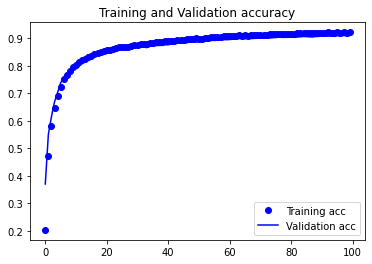

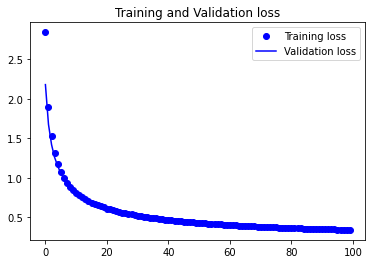

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

In [0]:
loss_and_metrics = model.evaluate(x=X_test[:test_size,:,:], y=y_test_one_hot[:test_size,:], batch_size=batch_size)

print(loss_and_metrics)

2752/2752 [==============================] - 2s 686us/step
[1.1734207428471988, 0.6348110437393188]


In [0]:
X_test.shape

In [0]:
model_json = model.to_json()
with open("/content/drive/My Drive/Capstone/model/SLT-model-101-68.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("/content/drive/My Drive/Capstone/model/SLT-model-101-68.h5")